# Exercise - Knowledge Base Agent - SOLUTION

In this exercise, you’ll build a Knowledge Base Agent using LangGraph, which can:

Efficiently process long documents using text embedding and chunking.
Retrieve information from a vector database.
Augment user queries with retrieved contextual documents.
Generate accurate responses using an LLM.


**Challenge**

Your task is to create a LangGraph Workflow that includes:

- A document loading and vectorization process for a knowledge base.
- An Agent Node capable of:
    - Retrieving relevant knowledge.
    - Augmenting responses with contextual documents.
    - Generating accurate answers.
- Conditional routing to control query resolution.
- Optimization techniques such as text chunking and embedding search.

By the end of this exercise, you’ll have built an AI-powered Knowledge Base Agent that uses a structured process to generate accurate answers.



## 0. Import the necessary libs

In [3]:
from typing import List
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from IPython.display import Image, display

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [6]:
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large"
)

## 2. Load and Process Documents

In [7]:
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn
)

In [8]:
file_path = "compact-guide-to-large-language-models.pdf"

In [9]:
loader = PyPDFLoader(file_path)

In [10]:
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200
)

In [12]:
all_splits = text_splitter.split_documents(pages)

In [13]:
_ = vector_store.add_documents(documents=all_splits)

## 3. Define State Schema

We define a State Schema for managing:

- User query
- Retrieved documents
- Generated answer

In [14]:
class State(MessagesState):
    question: str
    documents: List[Document]
    answer: str

## 4. RAG Nodes

The agent should:
- fetch relevant document chunks based on the user query
- combine the retrieved documents and use them as context
- invoke the LLM to generate a response

In [15]:
def retrieve(state: State):
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question)
    return {"documents": retrieved_docs}

In [16]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [17]:
def generate(state: State):
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

## 5. Build the LangGraph Workflow

In [18]:
workflow = StateGraph(State)

workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", END)

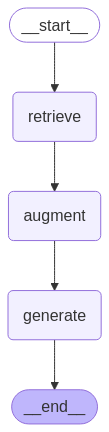

In [19]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 6. Invoke the Workflow with a Query

In [20]:
output = graph.invoke(
    {"question": "What are Open source models?"}
)

In [21]:
output["answer"]

'Open source models are language models developed and shared by the community, allowing users to access and utilize them for various tasks like text generation and classification. They offer advantages such as cost control, data privacy, and the ability to fine-tune the models to specific datasets. While they are rapidly improving, they have not yet fully matched the performance of proprietary models like GPT-4.'

In [22]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an assistant for question-answering tasks.
================================ Human Message =================================

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. 
# Question: 
-> What are Open source models? 
# Context: 
-> very limited use, so cost becomes a factor in applying these at scale.
In summary: Proprietary services are great to use if you have very complex tasks, 
are okay with sharing your data with a third party, and are prepared to incur 
costs if operating at any significant scale.  
Open source models
The other avenue for language models is to go to the open source community, 
where there has been similarly explosive growth over the past few years. 
Communities like Hugging Face  gather hundreds of thousands of models 
from contributo

## 7. Experiment

Now that you understood how it works, experiment with new things.

- Change the embedding model
- Change the parameters of RecursiveCharacterTextSplitter(chunk_size and chunk_overlap)
- Use your own document
- Add More File Types